In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Configurar path del proyecto
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_dir = os.path.dirname(current_dir)
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

# Importar nuestras funciones
from utils.utils_peliplat import (
    configurar_estilo_peliplat,
    mostrar_tabla,
    guardar_figura,
    COLORES_PELIPLAT,
    PALETA_MARCA
)
from src.analysis.segmentation import (
    preparar_datos_usuarios,
    segmentar_usuarios_por_visitas,
    calcular_distribucion_segmentos,
    calcular_estadisticas_segmento
)

from src.analysis.content import obtener_categoria_preferida, calcular_distribucion_contenido

# Configurar estilo
configurar_estilo_peliplat()

In [2]:
# Cargar datos
users = pd.read_csv('../data/processed/peliplat_users_clean.csv')
activity = pd.read_csv('../data/processed/peliplat_activity_clean.csv')
engagement = pd.read_csv('../data/processed/peliplat_engagement_clean.csv')
content = pd.read_csv('../data/processed/peliplat_content_clean.csv')

In [3]:
# Preparar y segmentar usuarios
users = preparar_datos_usuarios(users, activity)
users = segmentar_usuarios_por_visitas(users)

# Mostrar distribución de segmentos
segmentos_df = calcular_distribucion_segmentos(users)
mostrar_tabla(
    segmentos_df,
    titulo="Distribución de usuarios por segmento",
    guardar=True,
    nombre_archivo="distribucion_segmentos"
)


Distribución de usuarios por segmento


,Cantidad de usuarios,count
0,Recurrente,135
1,Nuevo,65


Tabla guardada en HTML: ../reports/tables\distribucion_segmentos.html
Tabla guardada en PNG: ../reports/tables\distribucion_segmentos.png



Estadísticas de actividad por segmento


Tabla guardada en HTML: ../reports/tables\estadisticas_por_segmento.html
Tabla guardada en PNG: ../reports/tables\estadisticas_por_segmento.png
Figura guardada en: ../reports/figures\distribucion_visitas_por_segmento.png


C:\Users\trico\AppData\Local\Temp\ipykernel_38296\3639488021.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


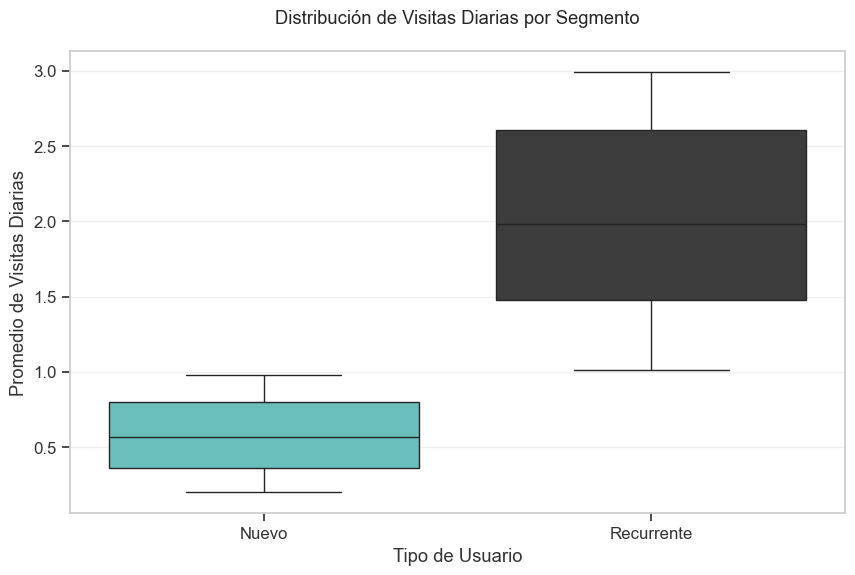

In [4]:
# Calcular estadísticas por segmento
columnas_metricas = ['avg_daily_visits', 'avg_time_on_page', 'days_active']
stats = calcular_estadisticas_segmento(users, columnas_metricas)

# Mostrar estadísticas
mostrar_tabla(
    stats,
    titulo="Estadísticas de actividad por segmento",
    guardar=True,
    nombre_archivo="estadisticas_por_segmento"
)

# Visualización de las diferencias
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=users, 
    x='segmento_visitas', 
    y='avg_daily_visits',
    palette=PALETA_MARCA[:2]
)
plt.title('Distribución de Visitas Diarias por Segmento', pad=20)
plt.xlabel('Tipo de Usuario')
plt.ylabel('Promedio de Visitas Diarias')

guardar_figura(plt.gcf(), 'distribucion_visitas_por_segmento.png')
plt.show()

# Obtener categoría preferida por usuario
content_user = obtener_categoria_preferida(content, engagement)

# Unir con usuarios
users = users.merge(content_user, on='user_id', how='left')

# Análisis de tipo de contenido más visto por segmento
contenido_tipo = calcular_distribucion_contenido(
    users, 
    columna_contenido='most_viewed_type'
)

mostrar_tabla(
    contenido_tipo,
    titulo="Distribución de tipo de contenido más visto por segmento (%)",
    guardar=True,
    nombre_archivo="distribucion_tipo_contenido"
)

# Análisis de categorías preferidas
categoria_preferida = calcular_distribucion_contenido(
    users, 
    columna_contenido='categoria_preferida'
)

mostrar_tabla(
    categoria_preferida,
    titulo="Distribución de categorías preferidas por segmento (%)",
    guardar=True,
    nombre_archivo="distribucion_categorias"
)

Figura guardada en: ../reports/figures\preferencias_contenido_por_segmento.png


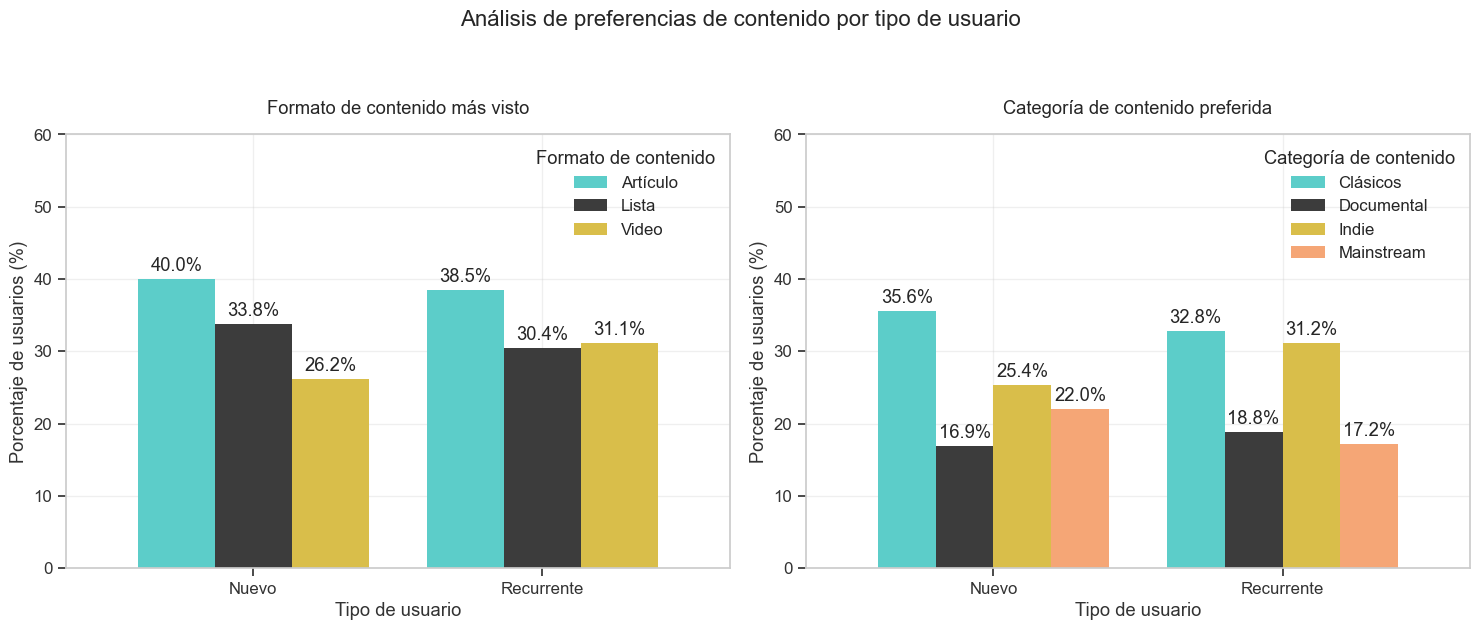

In [6]:
from src.analysis.content import graficar_preferencias_contenido

# Visualizar preferencias de contenido
graficar_preferencias_contenido(
    contenido_tipo=contenido_tipo,
    categoria_preferida=categoria_preferida,
    nombre_archivo='preferencias_contenido_por_segmento.png'
)

In [7]:
from src.analysis.engagement import preparar_datos_engagement, calcular_metricas_engagement
from src.analysis.segmentation import preparar_datos_usuarios, segmentar_usuarios_por_visitas

# Cargar y preparar datos base
users = pd.read_csv('../data/processed/peliplat_users_clean.csv')
activity = pd.read_csv('../data/processed/peliplat_activity_clean.csv')
engagement = pd.read_csv('../data/processed/peliplat_engagement_clean.csv')

# Preparar datos de usuarios y segmentación
users = preparar_datos_usuarios(users, activity)
users = segmentar_usuarios_por_visitas(users)

# Preparar datos de engagement
engagement_user = preparar_datos_engagement(engagement)

# Unir con usuarios y rellenar valores faltantes
users = users.merge(engagement_user, on='user_id', how='left')
users[['likes', 'shares', 'comments', 'engagement_score']] = users[
    ['likes', 'shares', 'comments', 'engagement_score']
].fillna(0)

# Calcular y mostrar estadísticas de engagement
engagement_stats = calcular_metricas_engagement(users)
mostrar_tabla(
    engagement_stats,
    titulo="Métricas de engagement promedio por tipo de usuario",
    guardar=True,
    nombre_archivo="engagement_por_segmento"
)


Métricas de engagement promedio por tipo de usuario


,likes,shares,comments,engagement_score
segmento_visitas,,,,
Nuevo,5.42,0.57,2.09,8.08
Recurrente,4.99,0.73,2.59,8.31


Tabla guardada en HTML: ../reports/tables\engagement_por_segmento.html
Tabla guardada en PNG: ../reports/tables\engagement_por_segmento.png


Figura guardada en: ../reports/figures\distribucion_engagement_por_segmento.png


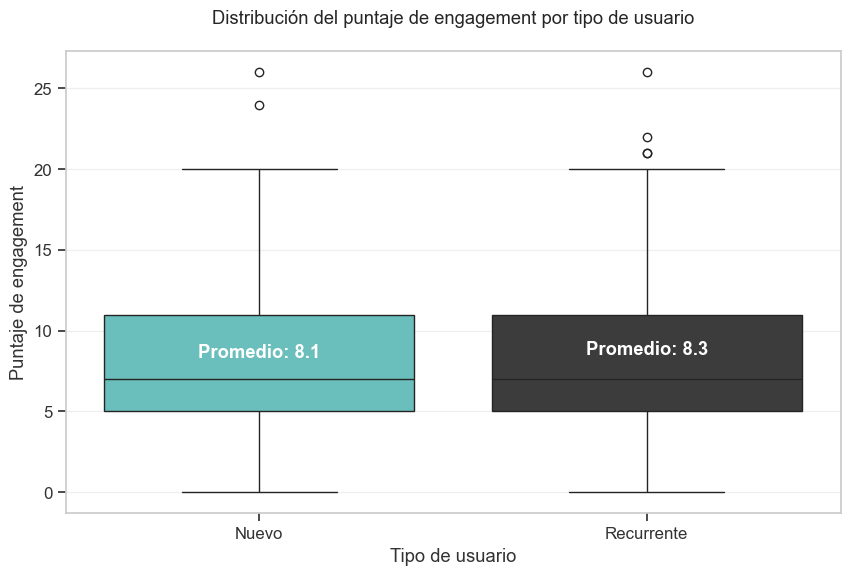

In [8]:
# Visualización del engagement
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=users, 
    x='segmento_visitas', 
    y='engagement_score',
    hue='segmento_visitas',
    palette=PALETA_MARCA[:2],
    legend=False
)
plt.title('Distribución del puntaje de engagement por tipo de usuario', pad=20)
plt.xlabel('Tipo de usuario')
plt.ylabel('Puntaje de engagement')

# Agregar valores promedio sobre los boxplots
for i, segmento in enumerate(users['segmento_visitas'].unique()):
    promedio = users[users['segmento_visitas'] == segmento]['engagement_score'].mean()
    plt.text(i, promedio, f'Promedio: {promedio:.1f}', 
             horizontalalignment='center', 
             verticalalignment='bottom',
             color='white',  # Texto en blanco
             fontweight='bold')

guardar_figura(plt.gcf(), 'distribucion_engagement_por_segmento.png')
plt.show()


Tasas de retención por segmento (%)


,Nuevo,Recurrente
7 días,89.23,94.81
14 días,84.62,85.19
30 días,70.59,73.95


Tabla guardada en HTML: ../reports/tables\retencion_por_segmento.html
Tabla guardada en PNG: ../reports/tables\retencion_por_segmento.png
Figura guardada en: ../reports/figures\retencion_por_segmento.png


<Figure size 1400x2000 with 0 Axes>

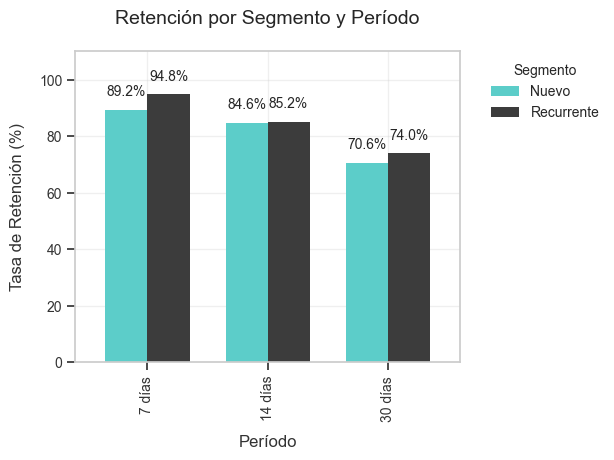

In [9]:
# Importar las funciones de retention.py
from src.analysis.retention import calcular_retencion_por_grupo

# Análisis de retención por segmento
# Convertir columnas de fecha a datetime
users['signup_date'] = pd.to_datetime(users['signup_date'])
users['last_active'] = pd.to_datetime(users['last_active'])

# Usar la función de retention.py
df_retencion = calcular_retencion_por_grupo(
    df=users,
    grupo='segmento_visitas',
    fecha_registro='signup_date',
    fecha_ultima_actividad='last_active',
    dias_activos='days_active',
    periodos=[7, 14, 30]
)

# Visualizar resultados usando mostrar_tabla
mostrar_tabla(
    df_retencion,
    titulo="Tasas de retención por segmento (%)",
    guardar=True,
    nombre_archivo="retencion_por_segmento"
)

# Crear gráfico de barras con mucho más espacio vertical
plt.figure(figsize=(14, 20))
ax = df_retencion.plot(
    kind='bar',
    color=PALETA_MARCA[:2],
    width=0.7
)

plt.title('Retención por Segmento y Período', pad=20, fontsize=14)
plt.xlabel('Período', labelpad=10, fontsize=12)
plt.ylabel('Tasa de Retención (%)', labelpad=10, fontsize=12)
plt.legend(
    title='Segmento', 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left',
    fontsize=10,
    title_fontsize=10
)
plt.grid(True, alpha=0.3)

# Añadir etiquetas de porcentaje con más espacio y fuente más pequeña
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=8, fontsize=10)

# Ajustar tamaño de los ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Ajustar márgenes y límites del eje y
plt.margins(x=0.1, y=0.2)
plt.ylim(0, 110)
plt.tight_layout()

guardar_figura(plt.gcf(), 'retencion_por_segmento.png')
plt.show()


Estadísticas de engagement para usuarios retenidos 30+ días


,count,mean,std,min,25%,50%,75%,max
segmento_visitas,,,,,,,,
Nuevo,36.00,7.81,5.63,0.00,4.75,7.00,10.25,26.00
Recurrente,88.00,8.38,5.31,0.00,4.00,7.00,11.00,22.00


Tabla guardada en HTML: ../reports/tables\stats_engagement_retenidos.html
Tabla guardada en PNG: ../reports/tables\stats_engagement_retenidos.png
Figura guardada en: ../reports/figures\engagement_usuarios_retenidos.png


<Figure size 1200x800 with 0 Axes>

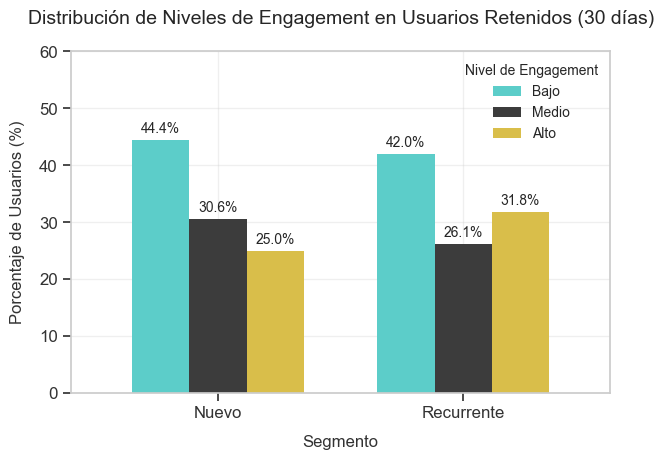

In [10]:
from src.analysis.engagement import (
    analizar_engagement_usuarios_retenidos,
    graficar_distribucion_engagement_retenidos
)

# Analizar engagement de usuarios retenidos
distribucion, stats = analizar_engagement_usuarios_retenidos(users, dias_retencion=30)

# Mostrar estadísticas
mostrar_tabla(
    stats,
    titulo="Estadísticas de engagement para usuarios retenidos 30+ días",
    guardar=True,
    nombre_archivo="stats_engagement_retenidos"
)

# Visualizar distribución
graficar_distribucion_engagement_retenidos(
    distribucion,
    titulo='Distribución de Niveles de Engagement en Usuarios Retenidos (30 días)',
    nombre_archivo='engagement_usuarios_retenidos.png'
)